In [34]:
#code source: https://www.kaggle.com/dhimananubhav/visualizing-analyzing-dow-jones-stocks

import numpy as np
import math
import matplotlib.pyplot as plt
%matplotlib inline
import time
import pandas as pd
import seaborn as sb
#import pandas.util.testing as tm

In [59]:
path = "BA.csv"

BA = pd.read_csv(path,parse_dates = ["Date"])  # make more space in each date

#AAPL.head()
#AAPL.describe()

BA = BA.rename(columns={"Close": "close","Open":"open","High":"high","Date":"date","Low":"low","Volume":"volume"})
BA

,date,open,high,low,close,Adj Close,volume
0,2019-04-15,376.700012,377.899994,373.679993,375.459991,366.666107,3822100
1,2019-04-16,376.510010,384.640015,375.029999,381.720001,372.779510,7083800
2,2019-04-17,384.100006,384.190002,377.480011,377.519989,368.677887,4424400
3,2019-04-18,377.519989,382.170013,377.519989,380.070007,371.168182,4703100
4,2019-04-22,375.690002,378.950012,374.899994,375.170013,366.382965,4147700
...,...,...,...,...,...,...,...
247,2020-04-07,162.000000,164.800003,140.259995,141.580002,141.580002,56699100
248,2020-04-08,147.509995,154.000000,144.550003,146.869995,146.869995,41351000
249,2020-04-09,154.710007,157.979996,150.089996,151.839996,151.839996,38049500
250,2020-04-13,155.500000,156.000000,146.259995,147.330002,147.330002,25951500


In [70]:
short_window = 40
long_window = 100

short_window = 10
long_window = 50

signals = pd.DataFrame(index=BA.index)
print(signals)
signals['signal'] = 0.0

Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, ...]

[252 rows x 0 columns]


In [71]:
signals['short_mavg'] = BA['close'].rolling(window=short_window, min_periods=1, center=False).mean()

# Create long simple moving average over the long window
signals['long_mavg'] = BA['close'].rolling(window=long_window, min_periods=1, center=False).mean()

# Create signals
signals['signal'][short_window:] = np.where(signals['short_mavg'][short_window:] > signals['long_mavg'][short_window:], 1.0, 0.0)   

# Generate trading orders
signals['positions'] = signals['signal'].diff()

In [72]:
# Set the initial capital
initial_capital= float(100000.0)

# Create a DataFrame `positions`
positions = pd.DataFrame(index=signals.index).fillna(0.0)

# Buy a 100 shares
positions['BA'] = 100*signals['signal']   
  
# Initialize the portfolio with value owned   
portfolio = positions.multiply(BA['close'], axis=0)

# Store the difference in shares owned 
pos_diff = positions.diff()

# Add `holdings` to portfolio
portfolio['holdings'] = (positions.multiply(BA['close'], axis=0)).sum(axis=1)

# Add `cash` to portfolio
portfolio['cash'] = initial_capital - (pos_diff.multiply(AAPL['close'], axis=0)).sum(axis=1).cumsum()   

# Add `total` to portfolio
portfolio['total'] = portfolio['cash'] + portfolio['holdings']

# Add `returns` to portfolio
portfolio['returns'] = portfolio['total'].pct_change()

In [73]:
returns = portfolio['returns']

# annualized Sharpe ratio
sharpe_ratio = np.sqrt(252) * (returns.mean() / returns.std())

# Print the Sharpe ratio
print(np.round(sharpe_ratio,2))

0.24


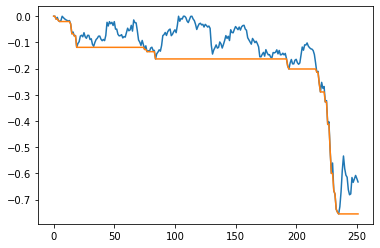

In [74]:
# Define a trailing 252 trading day window
window = 252

# Calculate the max drawdown in the past window days for each day
rolling_max = BA['close'].rolling(window, min_periods=1).max()
daily_drawdown = BA['close']/rolling_max - 1.0

# Calculate the minimum (negative) daily drawdown
max_daily_drawdown = daily_drawdown.rolling(window, min_periods=1).min()

# Plot the results
daily_drawdown.plot()
max_daily_drawdown.plot()

# Show the plot
plt.show()

In [75]:
# Get the number of days in `aapl`
days = (BA.index[-1] - BA.index[0]).days

#days = (AAPL.index[-1] - AAPL.index[0]).days

# Calculate the CAGR 
cagr = ((((BA['close'][-1]) / BA['close'][1])) ** (365.0/days)) - 1

# Print CAGR
print(np.round(cagr,3))

AttributeError: 'int' object has no attribute 'days'

In [ ]:
ph_df = BA.drop(['open', 'high', 'low','volume','Adj Close'], axis=1)
ph_df.reset_index(inplace=True)
ph_df.rename(columns={'close': 'y', 'date': 'ds'}, inplace=True)
ph_df['ds'] = pd.to_datetime(ph_df['ds'])
ph_df.head()

In [76]:
from fbprophet import Prophet
m = Prophet()
m.fit(ph_df)

# Create Future dates
future_prices = m.make_future_dataframe(periods=365)

# Predict Prices
forecast = m.predict(future_prices)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds,yhat,yhat_lower,yhat_upper
612,2021-04-10,-815.161618,-1006.981201,-632.493399
613,2021-04-11,-817.789182,-1011.041389,-624.005975
614,2021-04-12,-828.635548,-1023.886781,-644.134876
615,2021-04-13,-829.556706,-1024.836785,-639.164356
616,2021-04-14,-831.975472,-1025.156729,-640.254570


/Library/Code/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: MatplotlibDeprecationWarning:

Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.



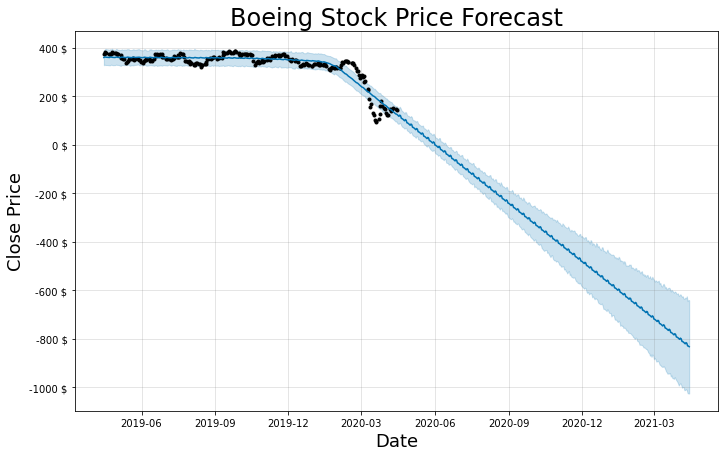

In [77]:
fig = m.plot(forecast)
ax1 = fig.add_subplot(111)
ax1.set_title("Boeing Stock Price Forecast", fontsize=24)
ax1.set_xlabel("Date", fontsize=18)
ax1.set_ylabel("Close Price", fontsize=18)
from matplotlib.ticker import FormatStrFormatter

font_xy = {'family' : 'cursive','stretch': 'ultra-condensed', 'weight' : 'normal','size'   : 36,}


plt.gca().yaxis.set_major_formatter(FormatStrFormatter('%d $'))
plt.show()